In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from jupyterthemes import jtplot
jtplot.style()

# Gaussian distribution

In [2]:
data_path = 'ex8data1.mat'
data = sio.loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


(307, 2)


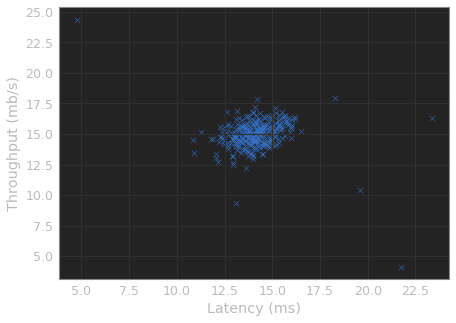

In [3]:
X = data['X']
X_val = data['Xval']
y_val = data['yval']
print(X.shape)

plt.grid = 'False'
plt.figure(figsize=[7, 5])
plt.scatter(X[:, 0], X[:, 1], marker='x', linewidth=0.5)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

In [4]:
def estimate_gaussian(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.std(X, axis=0)**2
    return mu, sigma2

<img style="background-color: #aa2222;" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b77e66e0cfdc9859e63d68b5309bb794ad7cd1aa"/>

$$ \frac{1}{\sigma_{1}\sigma_{2}2\pi} \exp \left( -\frac{(x_1 - \mu_1)^2}{2\sigma_1^2} -\frac{(x_2 - \mu_2)^2}{2\sigma_2^2} \right) $$

In [5]:
def gaussian(X, mu1, mu2, sig1, sig2):
    X1, X2 = X[:,0], X[:,1]
    exp = np.exp(-((X1-mu1)/(2*sig1))**2 - ((X2-mu2)/(2*sig2))**2)
    p = 1/(sig1*sig2*2*np.pi) * exp
    return p

In [6]:
def multivariate_gaussian(X, mu, sigma2):
    k = mu.shape[0]
    if sigma2.ndim == 1:
        sigma2 = np.diag(sigma2)

    X_norm = X - mu
    p = (2*np.pi)**(-k/2) * np.linalg.det(sigma2)**(-0.5)\
        * np.exp(-0.5 * np.sum(X_norm @ np.linalg.pinv(sigma2) * X_norm, axis=1))
    
    return p

In [133]:
def visualize_fit(X, mu, sigma2, new_fig=False, multivar=True):
    grid_coords = np.arange(0, 35, 0.5) # not linspace, you stupid donkey
    X1, X2 = np.meshgrid(grid_coords, grid_coords) 
    X12 = np.stack((X1.ravel(), X2.ravel()), axis=1)
    if multivar:
        Z = multivariate_gaussian(X12, mu, sigma2)
    else:
        mu1, sig1 = estimate_gaussian(X[:, 0])
        mu2, sig2 = estimate_gaussian(X[:, 1])
        Z = gaussian(X12, mu1, mu2, sig1, sig2)
        
    Z = Z.reshape(X1.shape)

    plt.grid = 'False'
    if new_fig: plt.figure(figsize=[10, 8])
    plt.scatter(X[:, 0], X[:, 1], marker='x', c='cyan', linewidth=0.5)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    
    if np.all(abs(Z) != np.inf):
        cont_levels = [10**exp for exp in range(-20,0,3)]
        plt.contour(X1, X2, Z, levels=cont_levels, cmap='autumn')

    plt.show()

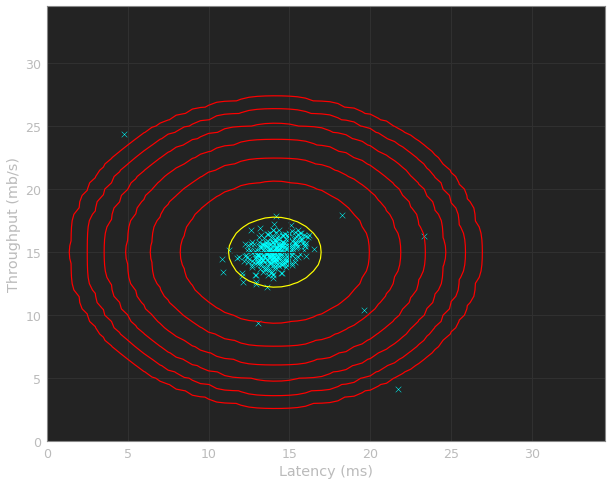

In [134]:
mu, sigma2 = estimate_gaussian(X)
visualize_fit(X, mu, sigma2, True)

# Selecting the threshold

In [126]:
def select_threshold(y_val, p_val):
    best_F1 = 0
    thresholds = np.linspace(1.01*np.min(p_val), np.max(p_val), 1000)
    for epsilon in thresholds:
        pred = (p_val < epsilon)
        tp = np.sum((pred == 1) & (y_val.ravel() == 1))
        fp = np.sum((pred == 1) & (y_val.ravel() == 0))
        fn = np.sum((pred == 0) & (y_val.ravel() == 1))
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        F1 = (2*prec*rec)/(prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon

    return best_epsilon, best_F1

In [127]:
p_val = multivariate_gaussian(X_val, mu, sigma2)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: ', epsilon)
print('Best F1 on Cross Validation Set: ', F1)

Best epsilon found using cross-validation:  8.999852631901394e-05
Best F1 on Cross Validation Set:  0.8750000000000001


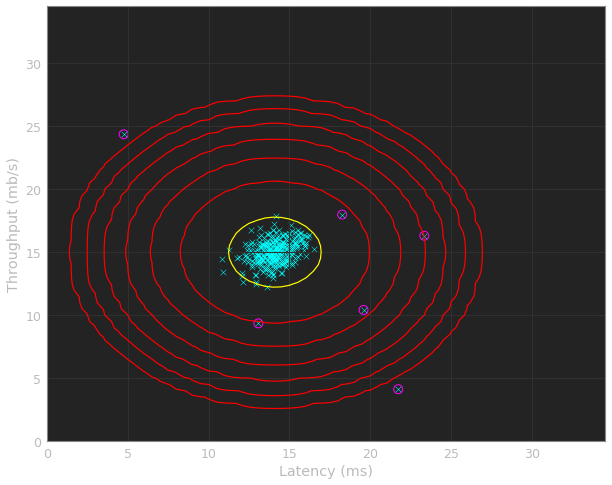

In [150]:
p = multivariate_gaussian(X, mu, sigma2)
outliners = (p < epsilon)
plt.figure(figsize=[10,8])
plt.scatter(X[outliners, 0], X[outliners, 1], s=80, marker='o', 
            facecolors='none', edgecolors='magenta', linewidth=1)
visualize_fit(X, mu, sigma2)

# High dimensional dataset

In [152]:
data_path2 = 'ex8data2.mat'
data2 = sio.loadmat(data_path2)
print(data2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


In [154]:
X2 = data2['X']
X_val2 = data2['Xval']
y_val2 = data2['yval']
print(X2.shape)

(1000, 11)


In [156]:
mu, sigma2 = estimate_gaussian(X2)
p = multivariate_gaussian(X2, mu, sigma2)
p_val = multivariate_gaussian(X_val2, mu, sigma2)
epsilon, F1 = select_threshold(y_val2, p_val)
print('Best epsilon found using cross-validation: ', epsilon)
print('Best F1 on Cross Validation Set: ', F1)
print('Outliers found: ', sum(p < epsilon))

Best epsilon found using cross-validation:  1.3786074987947634e-18
Best F1 on Cross Validation Set:  0.6153846153846154
Outliers found:  117
